# First Example
In this first example we will set up a basic pipeline to simulate the observation of an Earth twin (with a blackbody spectrum) around a Sun twin at 10 pc. We will assume an ideal instrument without any instrumental noise and simulate the spectrum that LIFE would measure under these circumstances.

**Import Necessary Modules**

We start by importing the necessary modules.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from phringe.core.entities.scene import Scene
from phringe.core.entities.sources.exozodi import Exozodi
from phringe.core.entities.sources.local_zodi import LocalZodi
from phringe.core.entities.sources.planet import Planet
from phringe.core.entities.sources.star import Star
from scipy.stats import ncx2, norm

from lifesimmc.core.modules.generating.data_generation_module import DataGenerationModule
from lifesimmc.core.modules.generating.template_generation_module import TemplateGenerationModule
from lifesimmc.core.modules.loading.setup_module import SetupModule
from lifesimmc.core.modules.processing.correlation_map_module import CorrelationMapModule
from lifesimmc.core.modules.processing.energy_detector_test_module import EnergyDetectorTestModule
from lifesimmc.core.modules.processing.ml_parameter_estimation_module import MLParameterEstimationModule
from lifesimmc.core.modules.processing.neyman_pearson_test_module import NeymanPearsonTestModule
from lifesimmc.core.modules.processing.variance_normalization_module import NoiseVarianceNormalizationModule
from lifesimmc.core.pipeline import Pipeline
from lifesimmc.lib.colormaps import cmap_blue
from lifesimmc.lib.instrument import LIFEReferenceDesign, InstrumentalNoise
from lifesimmc.lib.observation import LIFEReferenceObservation

### Simulation Setup


**Define Instrument and Observation**

We first define the `Instrument` and `Observation` objects.


In [2]:
# Use the predefined ideal LIFE baseline instrument, i.e. without any instrumental noise
inst = LIFEReferenceDesign(instrumental_noise=InstrumentalNoise.NONE)

# For this example, manually update the spectral resolving power and aperture diameter
inst.spectral_resolving_power = 30
inst.aperture_diameter = 2

# User the predefined observation for the LIFE baseline design
obs = LIFEReferenceObservation(
    total_integration_time='10 d',
    detector_integration_time='0.05 d',  # should be chosen small enough to sufficiently sample the planet signal
    optimized_star_separation='habitable-zone'
)

**Define Astrophysical Scene**

Next we define the astrophysical `Scene` and add `Star`, `LocalZodi`, `Exozodi` and `Planet` objects to it.

In [3]:
scene = Scene()

sun_twin = Star(
    name='Sun Twin',
    distance='10 pc',
    mass='1 Msun',
    radius='1 Rsun',
    temperature='5700 K',
    right_ascension='10 hourangle',
    declination='45 deg',
)

local_zodi = LocalZodi()

exozodi = Exozodi(level=3)

earth_twin = Planet(
    name='Earth Twin',
    has_orbital_motion=False,
    mass='1 Mearth',
    radius='1 Rearth',
    temperature='254 K',
    semi_major_axis='1 au',
    eccentricity='0',
    inclination='0 deg',
    raan='90 deg',
    argument_of_periapsis='0 deg',
    true_anomaly='45 deg',
    input_spectrum=None,
)

scene.add_source(sun_twin)
scene.add_source(local_zodi)
scene.add_source(exozodi)
scene.add_source(earth_twin)

**Set Up Pipeline**

Then we set up the pipeline by first creating a `Pipeline` object and then adding the `SetupModule`, to which we pass objects we have created above.


In [4]:
# Create the pipeline
pipeline = Pipeline(gpu_index=2, seed=42, grid_size=40)

# Setup the simulation
module = SetupModule(
    n_setup_out='setup',
    n_planet_params_out='params_init',
    instrument=inst,
    observation=obs,
    scene=scene
)
pipeline.add_module(module)

For an explanation of the arguments of the `Pipeline` object consider the documentation [here](../source/core/pipeline.rst).

### Data Generation

**Generate Raw Data**

Next we generate the raw data.

In [5]:
module = DataGenerationModule(n_setup_in='setup', n_data_out='data')
pipeline.add_module(module)

**Generate Templates**
 
For various processing steps we are going to need a grid of planetary templates. We choose a field of view of $10^{-6}\times 10^{-6}$ rad$^{2}$ and generate a template at each grid point that corresponds to the expected signal of the planet at that grid position.

In [6]:
module = TemplateGenerationModule(n_setup_in='setup', n_template_out='temp', fov=1e-6)
pipeline.add_module(module)

### Pre-Processing

**Normalize Data and Templates**

An integral part of the processing pipeline is tha handling of (co)variance of the data (and templates). If an unperturbed instrument is considered as in this example, we do not expect any correlations and we can simply normalize by the variance of the noise.


In [7]:
module = NoiseVarianceNormalizationModule(
    n_setup_in='setup',
    n_data_in='data',
    n_template_in='temp',  # Optional
    n_planet_params_in='params_init',
    n_data_out='data_norm',
    n_template_out='temp_norm',  # Optional
    n_transformation_out='norm',
)
pipeline.add_module(module)

Note that if a perturbed instrument is considered (e.g. `inst = LIFEReferenceDesign(instrumental_noise=InstrumentalNoise.OPTIMISTIC)`) the `NoiseVarianceNormalizationModule` is not applicable, as it can not properly handle the correlations introduced by the instrumental noise.

**Plot Correlation Map**

To get a first glimpse at our data we can correlate them with our grid of planetary templates: 

In [8]:
# Generate the correlation map
module = CorrelationMapModule(n_data_in='data_norm', n_template_in='temp_norm', n_image_out='imag_corr')
pipeline.add_module(module)

# Run pipeline with all modules we have added so far
pipeline.run()

# Get the correlation map from the image resource
imag_corr = pipeline.get_resource('imag_corr').get_image(as_numpy=True)

# Plot the image
plt.imshow(imag_corr, cmap=cmap_blue)
plt.colorbar()
plt.show()

Loading configuration...
Done
Generating synthetic data...


100%|██████████| 1/1 [00:00<00:00,  2.24it/s]

Done
Generating templates...
Done
Normalizing with noise variance...
Done
Resource imag_corr not found.


AttributeError: 'NoneType' object has no attribute 'get_image'

### Signal Extraction

**Extract the Planetary Spectrum**

We now extract the planetary spectrum and coordinates from our data using a (numerical) maximum likelihood estimation. This will take a few seconds to run.

In [12]:
module = MLParameterEstimationModule(
    n_setup_in='setup',
    n_data_in='data_norm',
    n_template_in='temp_norm',
    n_transformation_in='norm',
    n_planet_params_in='params_init',
    n_planet_params_out='params_ml',
)
pipeline.add_module(module)
pipeline.run()

Performing numerical MLE...
Done


Finally, we plot the extracted flux and corresponding uncertainties:

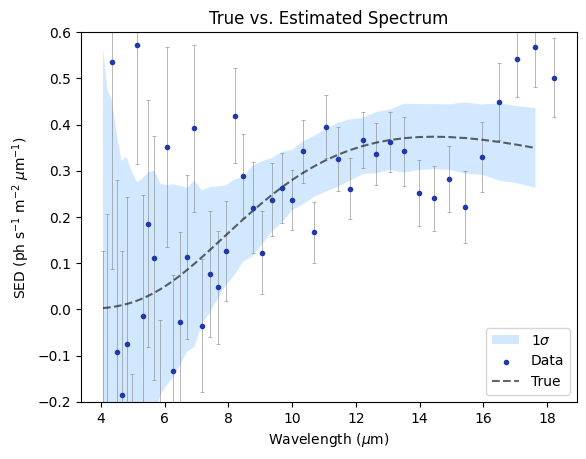

In [13]:
# Get the initial (input) parameters so we can plot the input spectrum (spectral energy distribution; SED) as a reference
params_init = pipeline.get_resource('params_init')
sed_init = params_init.params[0].sed.cpu().numpy()[:-1]  # Convert to numpy array from a torch Tensor
sed_init /= 1e6  # Convert to ph s-1 m-2 um-1
wavelengths = params_init.params[0].sed_wavelength_bin_centers.cpu().numpy()  # Convert to Torch tensor
wavelengths *= 1e6  # Convert from m to um

# Get the estimated parameters
params_ml = pipeline.get_resource('params_ml')
sed_estimated = params_ml.params[0].sed.cpu().numpy()
sed_estimated /= 1e6  # Convert to ph s-1 m-2 um-1
sed_err_low = params_ml.params[0].sed_err_low / 1e6
sed_err_high = params_ml.params[0].sed_err_high / 1e6

# Plot everything
yerr = np.stack([sed_err_low, sed_err_high])
plt.errorbar(
    wavelengths,
    sed_estimated,
    yerr=yerr,
    fmt='none',
    ecolor='gray',
    alpha=0.8,
    zorder=1,
    capsize=1.5,
    capthick=0.5,
    linewidth=0.5
)
plt.fill_between(
    wavelengths[:-1],
    np.array(sed_init) - np.array(sed_err_low)[:-1],
    np.array(sed_init) + np.array(sed_err_high)[:-1],
    color='dodgerblue',
    edgecolor=None,
    lw=0,
    alpha=0.2,
    label='1$\sigma$',
    zorder=0
)
plt.scatter(wavelengths, sed_estimated, label='Data', color="xkcd:sapphire", zorder=2, marker='.')
plt.plot(wavelengths[:-1], sed_init, label='True', linestyle='dashed', color='black', alpha=0.6, zorder=1)
plt.title('True vs. Estimated Spectrum')
plt.xlabel('Wavelength ($\mu$m)')
plt.ylabel('SED (ph s$^{-1}$ m$^{-2}$ $\mu$m$^{-1}$)')
plt.ylim(-0.2, 0.6)
plt.legend()
plt.show()

### Hypothesis Testing

**Energy Detector Test**

The energy detector test relies on the data only and does not assume any prior information on the contained planet signal (model). As such, it is a measure of the power contained in the data itself and not very sensitive, but is still useful as it provides a lower theoretical boundary for our detection problem.  



In [14]:
module = EnergyDetectorTestModule(
    n_setup_in="setup",
    n_data_in='data_norm',
    n_transformation_in='norm',
    n_planet_params_in='params_init',
    n_test_out='test_ed',
    pfa=0.00135  # Corresponds to a 3 sigma detection threshold
)
pipeline.add_module(module)
pipeline.run()

Performing energy detector test...
Done


We can now extract the $p$-value and check whether the detection is significant given our threshold of $0.00135$:

In [15]:
# Get resource and extract parameters
test_ed = pipeline.get_resource('test_ed')
pfa = test_ed.probability_false_alarm
p_value = test_ed.p_value

# Print detection result
if p_value <= pfa:
    print(f'Detected (p-value: {np.round(p_value, 4)})')
else:
    print(f'Not detected (p-value: {np.round(p_value, 4)})')

Detected (p-value: 0.0005)


Apparently, the planet is detected given a $3\sigma$-threshold. We can now illustrate this by drawing the distributions of the test statistics under the null hypothesis (no planet), $\mathcal{H}_0$, and alternative hypothesis (planet present), $\mathcal{H}_1$. For this we have used the true planet model contained in the `params_init` resource. This is also further explained in this excellent [tutorial by Romain Laugier](https://github.com/rlaugier/detection_tutorial/blob/master/detection_tutorial.ipynb).


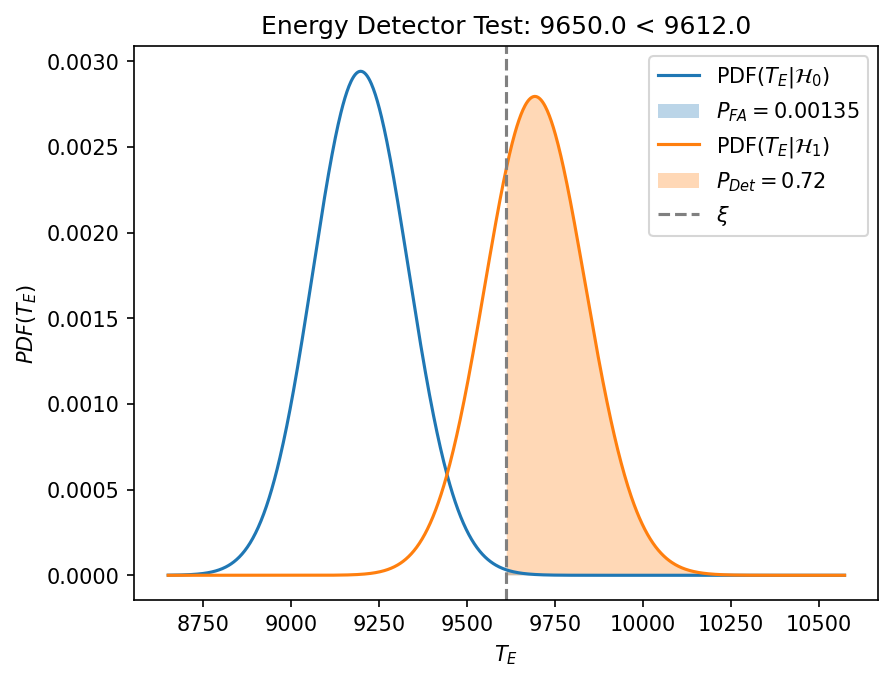

In [16]:
# Extract parameters
test_h1 = test_ed.test_statistic_h1
test_h0 = test_ed.test_statistic_h0
xsi = test_ed.threshold_xsi
xtx = test_ed.model_length_xtx
ndim = test_ed.dimensions
pdet = test_ed.detection_probability

# Plot distributions
z = np.linspace(0.9 * xsi, 1.1 * xsi, 1000)
zdet = z[z > xsi]
zndet = z[z < xsi]
fig = plt.figure(dpi=150)
plt.title(f'Energy Detector Test: {np.round(test_h1, 0)} < {np.round(xsi, 0)}')
plt.plot(z, ncx2.pdf(z, df=ndim, nc=0), label=f"PDF($T_{{E}} | \mathcal{{H}}_0$)")
plt.fill_between(zdet, ncx2.pdf(zdet, df=ndim, nc=0), alpha=0.3, label=f"$P_{{FA}}={pfa}$")
plt.plot(z, ncx2.pdf(z, df=ndim, nc=xtx), label=f"PDF($T_{{E}}| \mathcal{{H}}_1$)")
plt.fill_between(zdet, ncx2.pdf(zdet, df=ndim, nc=xtx), alpha=0.3, label=f"$P_{{Det}}={np.round(pdet, 2)}$")
plt.axvline(xsi, color="gray", linestyle="--", label=f"$\\xi$")
plt.xlabel(f"$T_{{E}}$")
plt.ylabel(f"$PDF(T_{{E}})$")
plt.legend()
plt.show()

**Neyman-Pearson Test**

The Neyman-Pearson test assumes perfect prior knowledge of the planet model for its test statistic. As such, it can be thought of as the upper theoretical limit of our detection problem. We repeat the same steps as for the energy detector test:


Performing Neyman-Pearson test...
Done
Detected (p-value: 0.0)


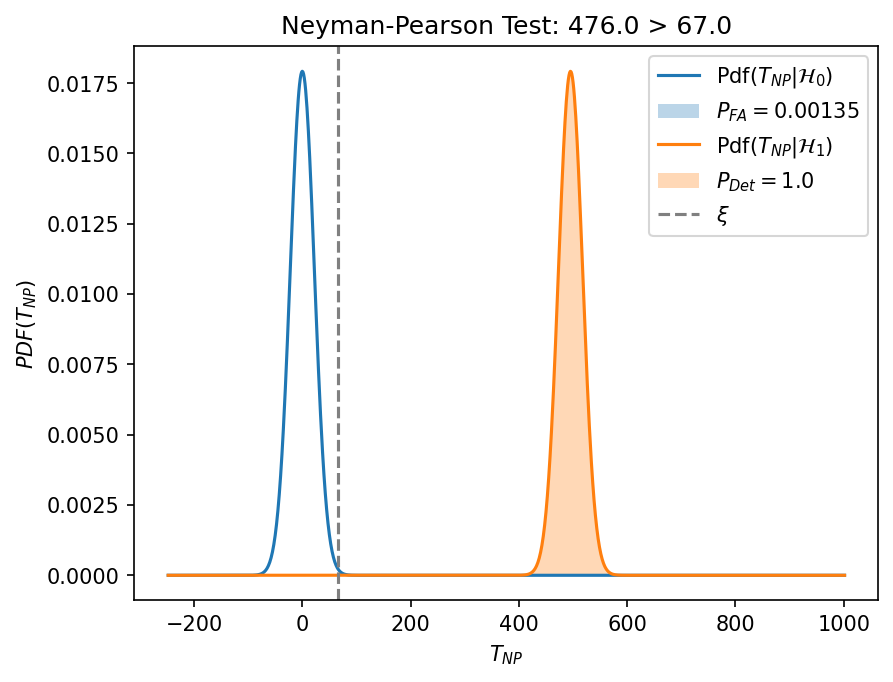

In [17]:
# Add module and run pipeline
module = NeymanPearsonTestModule(
    n_setup_in="setup",
    n_data_in='data_norm',
    n_transformation_in='norm',
    n_planet_params_true_in='params_init',
    n_planet_params_est_in='params_init',
    n_test_out='test_np',
    n_image_out='imag_np',
    pfa=0.00135  # Corresponds to a 3 sigma detection threshold
)
pipeline.add_module(module)
pipeline.run()

# Extract parameters from resource
test_np = pipeline.get_resource('test_np')
test_h1 = test_np.test_statistic_h1
test_h0 = test_np.test_statistic_h0
xsi = test_np.threshold_xsi
xtx = test_np.model_length_xtx
ndim = test_np.dimensions
pdet = test_np.detection_probability
pfa = test_np.probability_false_alarm
p_value = test_np.p_value

# Print detection result
if p_value <= pfa:
    print(f'Detected (p-value: {np.round(p_value, 4)})')
else:
    print(f'Not detected (p-value: {np.round(p_value, 4)})')

# Plot distributions
z = np.linspace(-0.5 * xtx, 15 * xsi, 1000)
zdet = z[z > xsi]
zndet = z[z < xsi]
fig = plt.figure(dpi=150)
plt.title(f'Neyman-Pearson Test: {np.round(test_h1, 0)} > {np.round(xsi, 0)}')
plt.plot(z, norm.pdf(z, loc=0, scale=np.sqrt(xtx)), label=f"Pdf($T_{{NP}} | \mathcal{{H}}_0$)")
plt.fill_between(zdet, norm.pdf(zdet, loc=0, scale=np.sqrt(xtx)), alpha=0.3,
                 label=f"$P_{{FA}}={pfa}$")
plt.plot(z, norm.pdf(z, loc=xtx, scale=np.sqrt(xtx)), label=f"Pdf($T_{{NP}}| \mathcal{{H}}_1$)")
plt.fill_between(zdet, norm.pdf(zdet, loc=xtx, scale=np.sqrt(xtx)), alpha=0.3, label=f"$P_{{Det}}={pdet}$")
plt.axvline(xsi, color="gray", linestyle="--", label=f"$\\xi$")
plt.xlabel(f"$T_{{NP}}$")
plt.ylabel(f"$PDF(T_{{NP}})$")
plt.legend()
plt.show()

Here, the planet is clearly detected, highlighted the much higher sensitivity of the Neyman-Pearson test compared to the energy detector test.